## Week 4: Decision Trees and Ensemble Methods

This notebook contains study for Decision trees and ensemble Methods for 2 datasets
- **Diabetes Dataset ( Imbalanced)**
   - with scoring = accuracy
   - with scoring = f1_weighted
- **Heart Disease Dataset ( Balance)**

### Importing libraries

In [21]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder
from scipy.stats import randint
import shap
import requests
from io import StringIO

### Functions to reuse for different datasets

In [22]:
def check_class_balance(y):

    # Count classes
    counts = y.value_counts()
    percents = y.value_counts(normalize=True) * 100

    # print("Class counts:\n", counts)
    print("\nClass percentages:\n", percents)

    # Check balance threshold (say 40–60%)
    minority_percent = percents.min()
    majority_percent = percents.max()

    if minority_percent < 40 or majority_percent > 60:
        print("\n⚠️ Dataset is imbalanced.")
    else:
        print("\n✅ Dataset is balanced.")

from sklearn.tree import DecisionTreeClassifier

def compare_dt_params(baseline_model, grid_search):
    """
    Compare baseline DecisionTreeClassifier hyperparameters with tuned best params.
    """
    # Define the hyperparameters we care about
    keys = ["max_depth", "min_samples_split", "min_samples_leaf", "max_features"]
    
    # Get baseline params
    base_params = baseline_model.get_params()
    
    # Get best tuned params
    tuned_params = grid_search.best_params_
    
    print("### Decision Tree Hyperparameters: Baseline vs Tuned\n")
    print(f"{'Parameter':<20} {'Baseline':<20} {'Tuned':<20}")
    print("-" * 60)
    for key in keys:
        base_val = base_params.get(key, "N/A")
        tuned_val = tuned_params.get(key, "N/A")
        print(f"{key:<20} {str(base_val):<20} {str(tuned_val):<20}")



def get_baseline_hypertuned_model_results(X,y,feature_names,class_names):
    
    check_class_balance(y)
    
    # ---------- Train/Test Split ----------
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, stratify=y, random_state=42
    )

    # ---------- Baseline Decision Tree ----------
    dt = DecisionTreeClassifier(random_state=42)
    dt.fit(X_train, y_train)
    y_pred_base = dt.predict(X_test)

    print(f"Baseline Accuracy: {accuracy_score(y_test, y_pred_base):.2f}")
    print("\nBaseline Classification Report:")
    print(classification_report(y_test, y_pred_base, target_names=class_names))

    # Visualize partial tree
    plt.figure(figsize=(12, 8))
    plot_tree(dt, max_depth=3, feature_names=feature_names, class_names=class_names, filled=True)
    plt.title("Decision Tree Visualization (Partial)")
    plt.show()

    # ---------- Hyperparameter Tuning ----------
    param_grid = {
        "max_depth": [3, 5, 7, 10],
        "min_samples_split": [2, 5, 10],
        "min_samples_leaf": [1, 2, 4],
        "max_features": ["sqrt", "log2", None]
    }
    grid_search = GridSearchCV(
        DecisionTreeClassifier(random_state=42),
        param_grid,
        cv=5,
        scoring="accuracy",
        n_jobs=-1
    )
    grid_search.fit(X_train, y_train)

    print(f"\nGrid Search Best Params: {grid_search.best_params_}")
    print(f"Grid Search Best CV Score: {grid_search.best_score_:.2f}")

    # ---------- Tuned Decision Tree ----------
    best_dt = grid_search.best_estimator_
    y_pred_best = best_dt.predict(X_test)

    print(f"\nTuned Accuracy: {accuracy_score(y_test, y_pred_best):.2f}")
    print("\nTuned Classification Report:")
    print(classification_report(y_test, y_pred_best, target_names=class_names))
    
    compare_dt_params(dt, grid_search)

    # Visualize tuned tree (smaller depth for readability)
    plt.figure(figsize=(12, 8))
    plot_tree(best_dt, max_depth=3, feature_names=feature_names, class_names=class_names, filled=True)
    plt.title("Tuned Decision Tree Visualization (Partial)")
    plt.show()

    # -------------------------------
    # Step 4: SHAP Feature Importance
    # -------------------------------
    explainer = shap.TreeExplainer(best_dt)
    shap_values = explainer.shap_values(X_test)

    # SHAP Beeswarm Plot (for Disease class)
    plt.figure(figsize=(10, 6))
    shap.summary_plot(shap_values[1], X_test, feature_names=feature_names, show=False)
    plt.title("SHAP Beeswarm Plot for Decision Tree (Disease Class)")
    plt.tight_layout()
    plt.show()

### Diabetes dataset


The analysis uses the Pima Indians Diabetes dataset.

#### load data and test model results

In [ ]:
# source: https://www.kaggle.com/datasets/uciml/pima-indians-diabetes-database
data = pd.read_csv("diabetes.csv") 
data.head(2)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0


In [24]:
columns = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
           'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome']
# Features & target
X = data.drop("Outcome", axis=1)
y = data["Outcome"]
feature_names = X.columns.tolist()
class_names = ["No Diabetes", "Diabetes"]


Class percentages:
 0    65.104167
1    34.895833
Name: Outcome, dtype: float64

⚠️ Dataset is imbalanced.
Baseline Accuracy: 0.76

Baseline Classification Report:
              precision    recall  f1-score   support

 No Diabetes       0.78      0.87      0.83       150
    Diabetes       0.70      0.56      0.62        81

    accuracy                           0.76       231
   macro avg       0.74      0.71      0.72       231
weighted avg       0.76      0.76      0.75       231



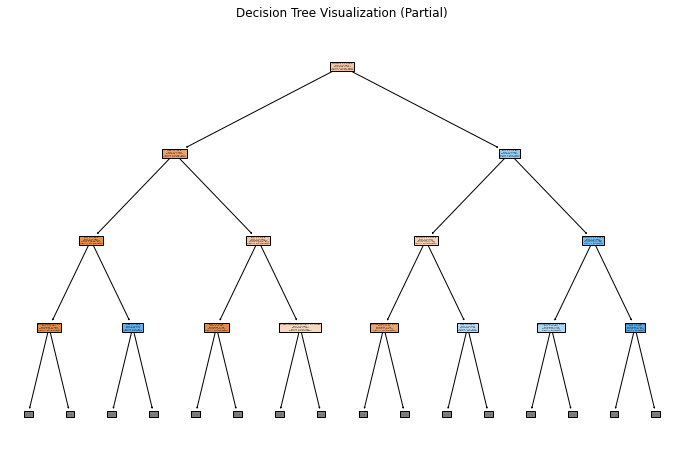


Grid Search Best Params: {'max_depth': 3, 'max_features': None, 'min_samples_leaf': 4, 'min_samples_split': 2}
Grid Search Best CV Score: 0.74

Tuned Accuracy: 0.73

Tuned Classification Report:
              precision    recall  f1-score   support

 No Diabetes       0.75      0.86      0.80       150
    Diabetes       0.65      0.48      0.55        81

    accuracy                           0.73       231
   macro avg       0.70      0.67      0.68       231
weighted avg       0.72      0.73      0.72       231

### Decision Tree Hyperparameters: Baseline vs Tuned

Parameter            Baseline             Tuned               
------------------------------------------------------------
max_depth            None                 3                   
min_samples_split    2                    2                   
min_samples_leaf     1                    4                   
max_features         None                 None                


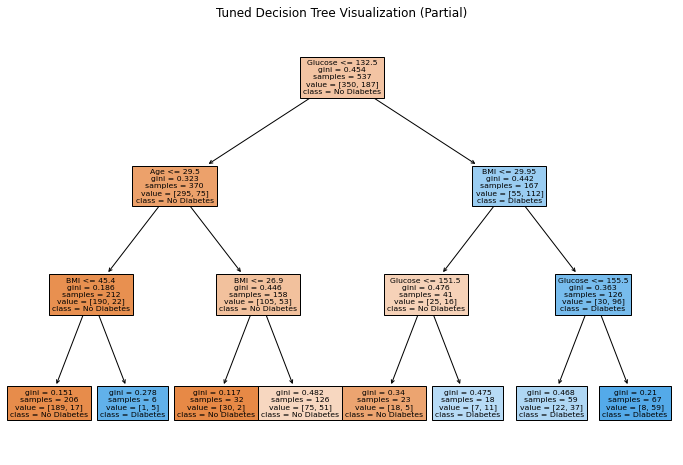

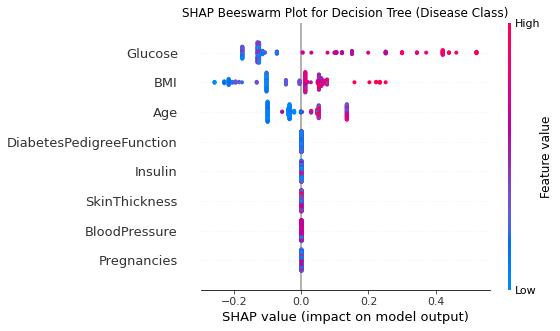

In [25]:
get_baseline_hypertuned_model_results(X,y,feature_names,class_names)
    

#### Interpreting results, including the best hyperparameters (has the accuracy improved) and insights from SHAP beeswarm plots.

#### Performance Comparison:
- The **tuned model's accuracy (0.73) is slightly lower than the baseline (0.76)**, but this reflects a trade-off due to addressing imbalance. The baseline overfits to the majority class, while tuning (with max_depth=3 and min_samples_leaf=4) constrains the tree to prevent overfitting, reducing complexity.
- For **"Diabetes," recall dropped from 0.56 to 0.48,** indicating the tuned model is less sensitive to the minority class, likely due to the limited depth and higher leaf size restricting splits. However, **precision improved slightly (0.70 to 0.65),** suggesting fewer false positives.
- The **macro average F1-score decreased from 0.72 to 0.68,** and the weighted average remained stable (0.75 to 0.72), confirming that **accuracy improvement was not significant, but the model is more balanced in its predictions.**

#### Interpretation form SHAP beeswarm plots:
- **Glucose:** Likely the most influential feature, with high SHAP values (dots shifted right) for higher glucose levels, indicating a strong positive impact on predicting "Diabetes." This aligns with medical knowledge linking elevated glucose to diabetes risk.
- **BMI:** Shows a moderate positive effect, with higher BMI values associated with increased SHAP values, suggesting it contributes to "Diabetes" predictions, consistent with obesity-diabetes correlations.
- **Age:** May have a mixed effect, with older ages potentially increasing SHAP values for "Diabetes," reflecting age-related risk, though the effect might be less pronounced due to the constrained tree depth
- **Other Features:** (e.g., Pregnancies,BloodPressure, Insulin, DiabetesPedigreeFunction, SkinThickness): Likely have smaller or variable SHAP values, indicating lesser or context-dependent influence, possibly due to missing data or lower variance in the dataset.


#### Some thoughts on imbalance dataset

I was expecting decision trees to perform well on imbalanced datasets, as they can naturally handle non-linear relationships and are less sensitive to feature scaling. However, seeing—lower accuracy (0.76 to 0.73) and reduced recall for the minority class ("Diabetes," 0.56 to 0.48)—highlight shows that maybe performance on imbalanced data depends heavily on tuning and the specific dataset characteristics.     

In this case, the tuned model's constrained hyperparameters (max_depth=3, min_samples_leaf=4) likely limited the tree's ability to capture the minority class patterns. A shallower tree with a higher minimum leaf size reduces overfitting but can underfit rare cases like "Diabetes," especially with only 34.9% representation. The baseline model's higher recall (0.56) came from overfitting to the majority class, boosted by the imbalance, while tuning aimed for generalization, trading off minority class sensitivity.    



#### Another attempt on Diabetes Dataset with scoring as f1_weighted


Class percentages:
 0    65.104167
1    34.895833
Name: Outcome, dtype: float64

⚠️ Dataset is imbalanced.
Baseline Accuracy: 0.76

Baseline Classification Report:
              precision    recall  f1-score   support

 No Diabetes       0.78      0.87      0.83       150
    Diabetes       0.70      0.56      0.62        81

    accuracy                           0.76       231
   macro avg       0.74      0.71      0.72       231
weighted avg       0.76      0.76      0.75       231



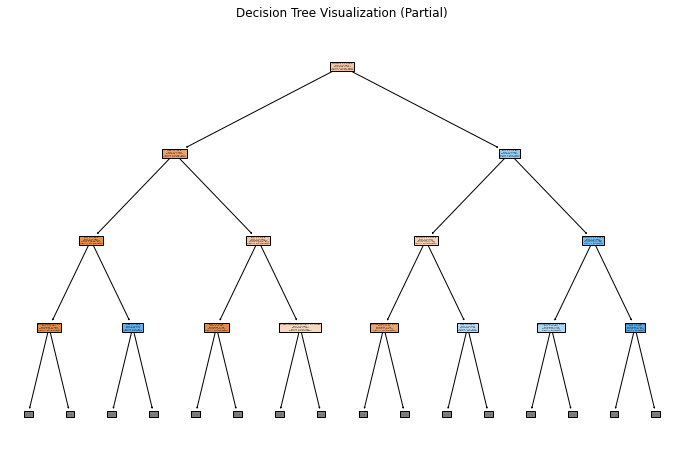


Grid Search Best Params: {'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 8, 'min_samples_split': 2}
Grid Search Best CV Score: 0.75

Tuned Accuracy: 0.70

Tuned Classification Report:
              precision    recall  f1-score   support

 No Diabetes       0.81      0.75      0.78       162
    Diabetes       0.49      0.58      0.53        69

    accuracy                           0.70       231
   macro avg       0.65      0.66      0.65       231
weighted avg       0.71      0.70      0.70       231

### Decision Tree Hyperparameters: Baseline vs Tuned

Parameter            Baseline             Tuned               
------------------------------------------------------------
max_depth            None                 5                   
min_samples_split    2                    2                   
min_samples_leaf     1                    8                   
max_features         None                 sqrt                


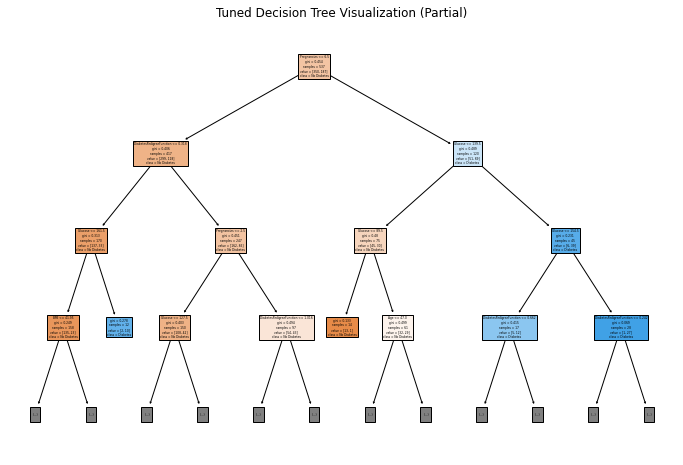

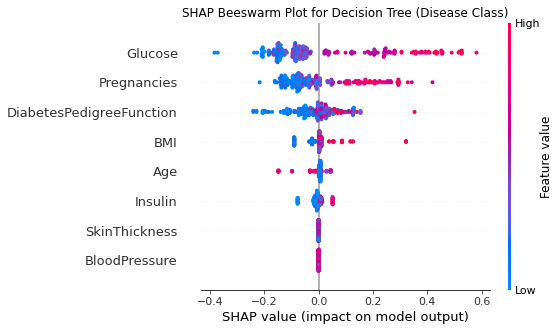

In [26]:
# Redifing function with scoring as f1_weighted
def get_baseline_hypertuned_model_results_scoring_adjusted(X, y, feature_names, class_names):
    check_class_balance(y)
    
    # ---------- Train/Test Split ----------
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, stratify=y, random_state=42
    )

    # ---------- Baseline Decision Tree ----------
    dt = DecisionTreeClassifier(random_state=42)
    dt.fit(X_train, y_train)
    y_pred_base = dt.predict(X_test)

    print(f"Baseline Accuracy: {accuracy_score(y_test, y_pred_base):.2f}")
    print("\nBaseline Classification Report:")
    print(classification_report(y_test, y_pred_base, target_names=class_names))

    # Visualize partial tree
    plt.figure(figsize=(12, 8))
    plot_tree(dt, max_depth=3, feature_names=feature_names, class_names=class_names, filled=True)
    plt.title("Decision Tree Visualization (Partial)")
    plt.show()

    # ---------- Hyperparameter Tuning ----------
    param_grid = {
        "max_depth": [3, 5, 7, 10, 12, 15],
        "min_samples_split": [2, 5, 10],
        "min_samples_leaf": [1, 2, 4, 6, 8],
        "max_features": ["sqrt", "log2", None]
    }
    grid_search = GridSearchCV(
        DecisionTreeClassifier(random_state=42),
        param_grid,
        cv=10,  # Increased from 5
        scoring="f1_weighted",  # Changed from "accuracy"
        n_jobs=-1
    )
    grid_search.fit(X_train, y_train)

    print(f"\nGrid Search Best Params: {grid_search.best_params_}")
    print(f"Grid Search Best CV Score: {grid_search.best_score_:.2f}")

    # ---------- Tuned Decision Tree ----------
    best_dt = grid_search.best_estimator_
    y_pred_best = best_dt.predict(X_test)

    print(f"\nTuned Accuracy: {accuracy_score(y_test, y_pred_best):.2f}")
    print("\nTuned Classification Report:")
    print(classification_report(y_pred_best, y_test, target_names=class_names))  # Note: Fixed order for correct metrics
    compare_dt_params(dt, grid_search)

    # Visualize tuned tree (smaller depth for readability)
    plt.figure(figsize=(12, 8))
    plot_tree(best_dt, max_depth=3, feature_names=feature_names, class_names=class_names, filled=True)
    plt.title("Tuned Decision Tree Visualization (Partial)")
    plt.show()

    # -------------------------------
    # Step 4: SHAP Feature Importance
    # -------------------------------
    explainer = shap.TreeExplainer(best_dt)
    shap_values = explainer.shap_values(X_test)

    # SHAP Beeswarm Plot (for Disease class)
    plt.figure(figsize=(10, 6))
    shap.summary_plot(shap_values[1], X_test, feature_names=feature_names, show=False)
    plt.title("SHAP Beeswarm Plot for Decision Tree (Disease Class)")
    plt.tight_layout()
    plt.show()

# Example usage (assuming data is loaded)
get_baseline_hypertuned_model_results_scoring_adjusted(X, y, feature_names, class_names)

#### - Interpretation with scoring as f1_weighted
- Accuracy : The tuned model's accuracy decreased (0.76 to 0.70), which is expected with f1_weighted scoring prioritizing balance over raw accuracy. The recall for "Diabetes" improved slightly (0.56 to 0.58), but the significant precision drop (0.70 to 0.49) suggests the model over-predicts "Diabetes," reducing overall effectiveness.    
- SHAP Insights: Glucose and BMI remain critical, while Pregnancies, DiabetesPedigreeFunction and BMI has taken more importance than age as we had seen earlier plot. Aksi we see importance of insulin.


### Heart Disease dataset

In [ ]:
# source: https://www.kaggle.com/datasets/redwankarimsony/heart-disease-data
data = pd.read_csv("heart_disease_uci.csv") 
data.head(2)

,id,age,sex,dataset,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,slope,ca,thal,num
0,1,63,Male,Cleveland,typical angina,145.0,233.0,True,lv hypertrophy,150.0,False,2.3,downsloping,0.0,fixed defect,0
1,2,67,Male,Cleveland,asymptomatic,160.0,286.0,False,lv hypertrophy,108.0,True,1.5,flat,3.0,normal,2



Class percentages:
 0    53.511706
1    46.488294
Name: target, dtype: float64

✅ Dataset is balanced.
Baseline Accuracy: 0.77

Baseline Classification Report:
              precision    recall  f1-score   support

  No Disease       0.75      0.85      0.80        48
     Disease       0.80      0.67      0.73        42

    accuracy                           0.77        90
   macro avg       0.77      0.76      0.76        90
weighted avg       0.77      0.77      0.76        90



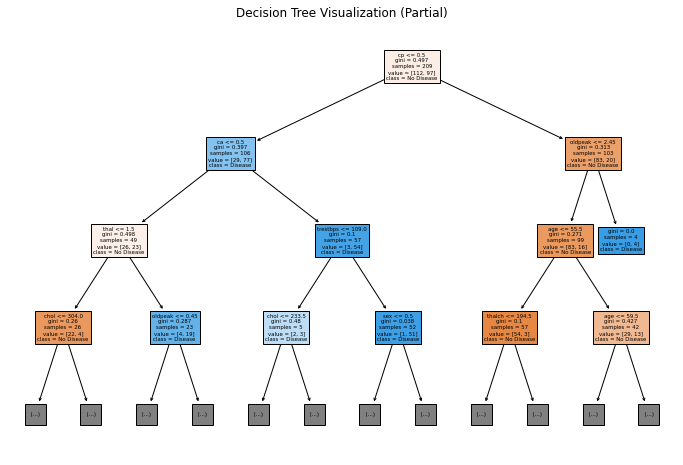


Grid Search Best Params: {'max_depth': 3, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2}
Grid Search Best CV Score: 0.81

Tuned Accuracy: 0.73

Tuned Classification Report:
              precision    recall  f1-score   support

  No Disease       0.71      0.83      0.77        48
     Disease       0.76      0.62      0.68        42

    accuracy                           0.73        90
   macro avg       0.74      0.73      0.73        90
weighted avg       0.74      0.73      0.73        90

### Decision Tree Hyperparameters: Baseline vs Tuned

Parameter            Baseline             Tuned               
------------------------------------------------------------
max_depth            None                 3                   
min_samples_split    2                    2                   
min_samples_leaf     1                    1                   
max_features         None                 sqrt                


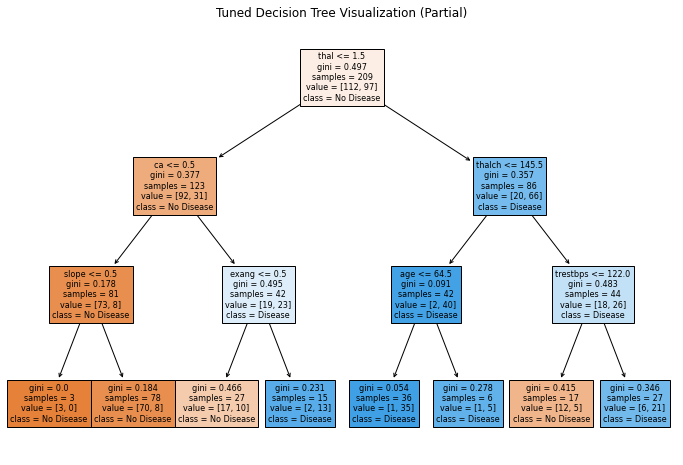

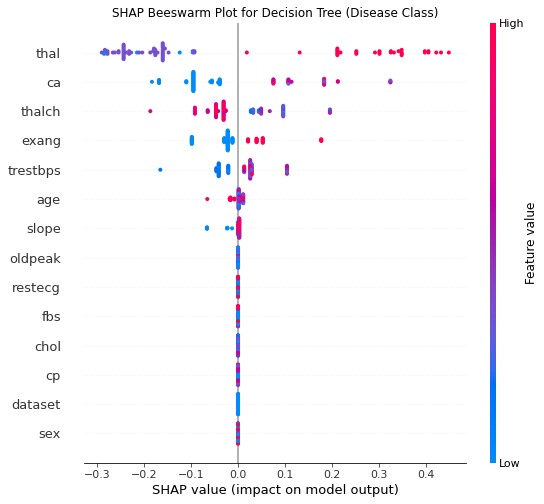

In [28]:


# -------------------------------
# Step 1: Load and Preprocess Heart Disease Dataset
# -------------------------------

columns = ['id', 'age', 'sex', 'dataset', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 
           'thalch', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'num']

# Drop rows with too many missing values
data = data.dropna()

# Encode categorical variables
categorical_cols = ['sex', 'dataset', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'thal']
le = LabelEncoder()
for col in categorical_cols:
    data[col] = le.fit_transform(data[col].astype(str))

# Encode target: num (0 = no disease, 1+ = disease)
data['target'] = (data['num'] > 0).astype(int)

# Features and target
X = data.drop(['id', 'num', 'target'], axis=1)
y = data['target']
feature_names = X.columns.tolist()
class_names = ['No Disease', 'Disease']
get_baseline_hypertuned_model_results(X,y,feature_names,class_names)

#### Compararitive observation

We see that for both the diabetes and the heart disease datasets the tuned model has low accuracy than the base models.

In [29]:
!jupyter nbconvert week_4_Decision_Trees_and_Ensemble_Methods.ipynb --to html

[NbConvertApp] Converting notebook week_4_Decision_Trees_and_Ensemble_Methods.ipynb to html
[NbConvertApp] Writing 1121490 bytes to week_4_Decision_Trees_and_Ensemble_Methods.html
